In [1]:
# IMPORT STATEMENTS AND PRELIMINARIES

import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy import stats

pi = np.pi

MAINPATH = '/Users/research/projects/alderaan/'

# Read in Kepler DR25

In [2]:
# file names
dr25_file = MAINPATH + 'Catalogs/kepler_dr25.csv'

# convenience function to read in csv file
def read_csv_file(filename):
    data = []
    with open(filename) as infile:
        reader = csv.reader(infile)

        for row in reader:
            data.append(row)

        if filename == dr25_file:
            keys   = data[0]
            values = data[1:]

            
        return keys, values


# READ IN DR25 DATABASE -- https://exoplanetarchive.ipac.caltech.edu
dr25_keys, dr25_data = read_csv_file(dr25_file)

In [3]:
# convenience functions to pull data from csv files
def getdr25(keyname,keys=dr25_keys,data=dr25_data):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    outdata = []
    for row in data:
        outdata.append(row[kid])
    
    return outdata

In [4]:
# read dr25 data into a dictionary
dr25 = {}
for k in dr25_keys:
    dr25[k] = getdr25(k)

In [5]:
def check_lengths(data):
    keys = data.keys()
    k0   = list(keys)[0]
    L0   = len(data[k0])
    
    for k in keys:
        if len(data[k]) != L0:
            raise ValueError('inconsistent array lengths')
            
    return None


def convert_to_arrays(data):
    keys = data.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(data[k])
        
    return dnew       



# grab a reference key
dr25_k0 = list(dr25.keys())[0]


# convert to arrays
dr25 = convert_to_arrays(dr25)
print('total number of queried DR25 objects =', len(dr25[dr25_k0]))


check_lengths(dr25)

total number of queried DR25 objects = 9564


# Read in Gaia DR2

In [6]:
gaiapath = MAINPATH + "Catalogs/berger_2020_gaia_kepler_tab2_output.txt"

# read in the stellar output parameters
with open(gaiapath, "r") as infile:
    raw_gaia_data = []
    
    for i, line in enumerate(infile):
        raw_gaia_data.append(line.split("&"))
            
raw_gaia_data = np.array(raw_gaia_data)


# strip off trailing \newline commands
for i in range(len(raw_gaia_data)):
    raw_gaia_data[i,-1] = raw_gaia_data[i,-1].strip("\n").strip("\ ")

In [7]:
raw_gaia_dict = {}

for i, k in enumerate(raw_gaia_data[0]):
    raw_gaia_dict[k] = raw_gaia_data[1:,i]

In [8]:
gaia = {}

gaia['kic']          = raw_gaia_dict['KIC']

gaia['Teff']         = raw_gaia_dict['iso_teff']
gaia['Teff_err1']    = raw_gaia_dict['iso_teff_err1']
gaia['Teff_err2']    = raw_gaia_dict['iso_teff_err2']

gaia['FeH']          = raw_gaia_dict['iso_feh']
gaia['FeH_err1']     = raw_gaia_dict['iso_feh_err1']
gaia['FeH_err2']     = raw_gaia_dict['iso_feh_err2']

gaia['Mstar']        = raw_gaia_dict['iso_mass']
gaia['Mstar_err1']   = raw_gaia_dict['iso_mass_err1']
gaia['Mstar_err2']   = raw_gaia_dict['iso_mass_err2']

gaia['Rstar']        = raw_gaia_dict['iso_rad']
gaia['Rstar_err1']   = raw_gaia_dict['iso_rad_err1']
gaia['Rstar_err2']   = raw_gaia_dict['iso_rad_err2']

gaia['rhostar']      = raw_gaia_dict['iso_rho']
gaia['rhostar_err1'] = raw_gaia_dict['iso_rho_err1']
gaia['rhostar_err2'] = raw_gaia_dict['iso_rho_err2']

# Remove false-positives and low SNR objects

In [9]:
# remove false positives from DR25
fp = dr25['koi_disposition'] == 'FALSE POSITIVE'
fp += (dr25['koi_disposition'] != 'CONFIRMED')*(dr25['koi_pdisposition'] == 'FALSE POSITIVE')

for k in dr25.keys():
    dr25[k] = dr25[k][~fp]

print('after removing false positives, DR25 objects =', len(dr25[dr25_k0]))

after removing false positives, DR25 objects = 4541


In [10]:
# cut DR25 low signal-to-noise objects (SNR < 7.1)
dr25_snr = dr25['koi_model_snr']
dr25_snr[dr25_snr == ''] = 0
dr25_snr = np.array(dr25_snr, dtype='float')

for k in dr25.keys():
    dr25[k] = dr25[k][dr25_snr >= 7.1]
    
print('after cutting on SNR > 7.1, DR25 objects =', len(dr25[dr25_k0]))

after cutting on SNR > 7.1, DR25 objects = 4341


# Initialize my catalog

In [11]:
Nobj = len(dr25['kepid'])

In [12]:
my_catalog = {}

my_catalog['planet_name'] = dr25['kepoi_name']
my_catalog['disposition'] = dr25['koi_disposition']

my_catalog['koi_id']  = np.array(['K00000']*Nobj)
my_catalog['kic_id']  = dr25['kepid']
#my_catalog['gaia_id'] = np.ones(Nobj, dtype=gaia['gaia_id'].dtype)

my_catalog['npl'] = dr25['koi_count']
my_catalog['kep_mag'] = np.array(dr25['koi_kepmag'], dtype='float').round(3)

my_catalog['rstar'] = dr25['koi_srad']
my_catalog['rstar_err1'] = dr25['koi_srad_err1']
my_catalog['rstar_err2'] = dr25['koi_srad_err2']

my_catalog['mstar'] = dr25['koi_smass']
my_catalog['mstar_err1'] = dr25['koi_smass_err1']
my_catalog['mstar_err2'] = dr25['koi_smass_err2']

my_catalog['epoch'] = dr25['koi_time0']
my_catalog['epoch_err1'] = dr25['koi_time0_err1']
my_catalog['epoch_err2'] = dr25['koi_time0_err2']

my_catalog['period'] = dr25['koi_period']
my_catalog['period_err1'] = dr25['koi_period_err1']
my_catalog['period_err2'] = dr25['koi_period_err2']

my_catalog['depth'] = dr25['koi_depth']
my_catalog['depth_err1'] = dr25['koi_depth_err1']
my_catalog['depth_err2'] = dr25['koi_depth_err2']

my_catalog['duration'] = dr25['koi_duration']
my_catalog['duration_err1'] = dr25['koi_duration_err1']
my_catalog['duration_err2'] = dr25['koi_duration_err2']

In [13]:
# make KOI name for star
for i, pname in enumerate(my_catalog['planet_name']):
    my_catalog['koi_id'][i] = pname[:-3]

In [14]:
# replace empty values with zeros
for i, k in enumerate(my_catalog.keys()):
    bad = (my_catalog[k] == '')
    
    my_catalog[k][bad] = 0

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


# Cross-match Kepler vs. Gaia and combine

#### This section uses Berger+ 2018 which only includes stellar radii; the catalog from Berger+ 2020 will soon be available and that will also include stellar masses

In [15]:
dr25_kic = np.array(dr25['kepid'], dtype='int')
gaia_kic = np.array(gaia['kic'], dtype='int')

len(dr25_kic), len(gaia_kic)

(4341, 186301)

In [16]:
# update Kepler stellar radii and masses to Gaia values where available
use = np.isin(dr25_kic, gaia_kic)

for i, kic in enumerate(dr25_kic):
    if use[i]:
        my_catalog['rstar'][i] = np.squeeze(gaia['Rstar'][gaia_kic == kic])
        my_catalog['rstar_err1'][i] = np.squeeze(gaia['Rstar_err1'][gaia_kic == kic])
        my_catalog['rstar_err2'][i] = np.squeeze(gaia['Rstar_err2'][gaia_kic == kic])
        
        my_catalog['mstar'][i] = np.squeeze(gaia['Mstar'][gaia_kic == kic])
        my_catalog['mstar_err1'][i] = np.squeeze(gaia['Mstar_err1'][gaia_kic == kic])
        my_catalog['mstar_err2'][i] = np.squeeze(gaia['Mstar_err2'][gaia_kic == kic])

# convert radius and mass to floats
my_catalog['rstar'] = np.array(my_catalog['rstar'], dtype='float')
my_catalog['rstar_err1'] = np.array(my_catalog['rstar_err1'], dtype='float')
my_catalog['rstar_err2'] = np.array(my_catalog['rstar_err2'], dtype='float')

my_catalog['mstar'] = np.array(my_catalog['mstar'], dtype='float')
my_catalog['mstar_err1'] = np.array(my_catalog['mstar_err1'], dtype='float')
my_catalog['mstar_err2'] = np.array(my_catalog['mstar_err2'], dtype='float')

# Adjust number of planets in each system

In [21]:
# adjust number of planets in each system to reflect removals 
unique_systems = np.unique(my_catalog['koi_id'])

my_catalog['npl'] = np.zeros(len(my_catalog['koi_id']), dtype='int')

for us in unique_systems:
    new_npl = np.sum(my_catalog['koi_id'] == us)
    my_catalog['npl'][my_catalog['koi_id'] == us] = new_npl

(array([2628.,  904.,  471.,  208.,  105.,   18.,    7.,    0.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

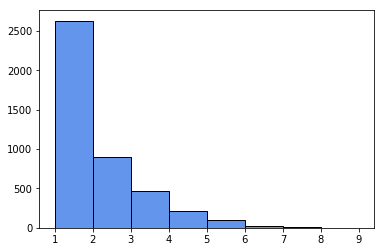

In [22]:
plt.hist(np.array(my_catalog['npl'], dtype='float'), bins=np.arange(1,10), color='cornflowerblue', edgecolor='k')

# Read out catalogue

In [23]:
WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'Catalogs/clean_kepler_catalog.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(my_catalog.keys())
        writer.writerows(zip(*my_catalog.values()))